**Install & Import libraries**

In [1]:
!pip install torch torchvision matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



**Load Dataset**

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.8MB/s]


**Build VAE Architecture**

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()

        # Encoder
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


**Loss Function**

In [5]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


**Train the model**

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []

for epoch in range(10):
    total_loss = 0
    for x, _ in train_loader:
        x = x.view(-1, 28*28).to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss = vae_loss(recon, x, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg = total_loss / len(train_loader.dataset)
    losses.append(avg)
    print(f"Epoch {epoch+1}, Loss: {avg:.2f}")


Epoch 1, Loss: 165.98
Epoch 2, Loss: 122.28
Epoch 3, Loss: 114.92
Epoch 4, Loss: 111.80
Epoch 5, Loss: 109.94
Epoch 6, Loss: 108.84
Epoch 7, Loss: 107.97
Epoch 8, Loss: 107.36
Epoch 9, Loss: 106.84
Epoch 10, Loss: 106.36


**Plot the Loss Curve **

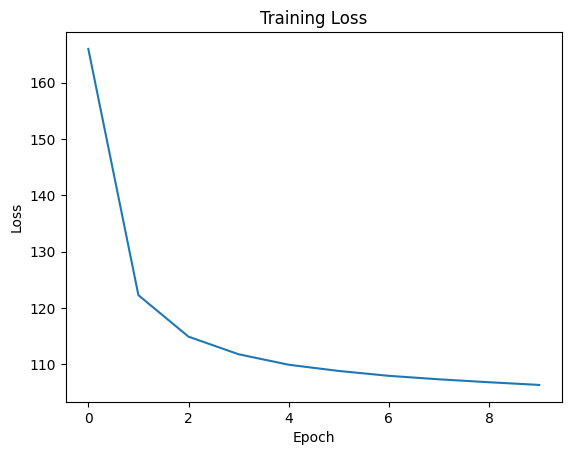

In [7]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


**Reconstructed Images (Expected Output)**

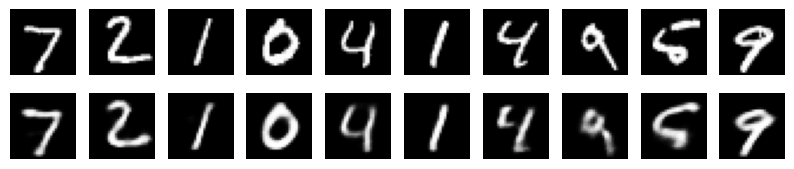

In [8]:
model.eval()

with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.view(-1, 28*28).to(device)

    recon, _, _ = model(x)

    x = x.cpu()
    recon = recon.cpu()

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x[i].view(28,28), cmap="gray")
    plt.axis("off")

    plt.subplot(2,10,i+11)
    plt.imshow(recon[i].view(28,28), cmap="gray")
    plt.axis("off")

plt.show()


**Generate New Samples**

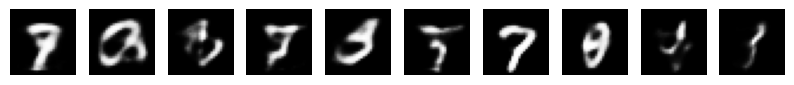

In [9]:
with torch.no_grad():
    z = torch.randn(10, 20).to(device)
    samples = model.decode(z).cpu()

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(samples[i].view(28,28), cmap="gray")
    plt.axis("off")

plt.show()
